# It works, we need to add a dvergence free constraint!!!

In [1]:
from ngsolve import *
from netgen.occ import *
from ngsolve.webgui import Draw

In [2]:
shape = Box((-1,-1,-1), (1,1,1)) # create a box
geo = OCCGeometry(shape) # create a geometry from the box
mesh = Mesh(geo.GenerateMesh(maxh=0.2)) # create a mesh from the geometry
#Draw (mesh); # draw the mesh

In [3]:
order = 2
Hcc = HCurlCurl(mesh, order=order) # for the gamma variable
Hdd = HDivDiv(mesh, order=order ) # , orderinner=order+1) fr t
# fesalpha = H1(mesh, order=order+1) # , dirichlet=".*")
Hc = HCurl(mesh, order=order-1) # for the div of a Hdd field

k , dk= Hdd.TnT() 
p, dp = Hc.TnT()
g, dg = Hcc.TnT()

In [4]:
n = specialcf.normal(3)
t = specialcf.tangential(3, True)
bbndtang  = specialcf.EdgeFaceTangentialVectors(3)
tef1 = bbndtang[:,0]
tef2 = bbndtang[:,1]
nu1 = Cross(tef1,t)
nu2 = Cross(tef2,t)

def IncOp(g, dg):
    return InnerProduct(curl(g), curl(dg).trans)*dx \
        + (curl(g)*n) * Cross (dg*n, n) * dx(element_vb=BND) \
        + (curl(dg)*n) * Cross (g*n, n) * dx(element_vb=BND) \
        + (g[nu1,t]*dg[t,tef1]-g[nu2,t]*dg[t,tef2])*dx(element_vb=BBND)

# print ( (gamma*nu1*t)*(dgamma*t*tef1))

def J(g): return g - 0.5*Trace(g)*Id(3)

def Constraint(k, p):
    return  div( k)*p * dx - InnerProduct(k*n - k[n,n]*n , p - (p*n)*n ) * dx(element_boundary = True)

def Curl(u):
    if u.dim == 3:
        return CF( (u[1].Diff(z)- u[2].Diff(y), u[2].Diff(x)- u[0].Diff(z), u[0].Diff(y)- u[1].Diff(x)) )
    if u.dim == 9:
        return CF( (Curl(u[0,:]),Curl(u[1,:]),Curl(u[2,:])),dims=(3,3) )

def Transpose(u):
    return CF( (u[0,0] , u[1,0] , u[2,0] , u[0,1] , u[1,1] , u[2,1] , u[0,2] , u[1,2] , u[2,2] ),dims=(3,3) )

def Symetric(u): return u + Transpose(u) 

In [5]:

MINC = BilinearForm(IncOp(g,dg))

Mcc = BilinearForm(InnerProduct(g, dg)*dx)
Mdd = BilinearForm(InnerProduct(k, dk)*dx)

Mccdd = BilinearForm(trialspace=Hcc, testspace=Hdd)
Mccdd += InnerProduct(g, dk)*dx

MJdd = BilinearForm(trialspace=Hdd, testspace=Hdd)
MJdd += InnerProduct(k, dk)*dx-0.5*Trace(k)*Trace(dk)*dx

with TaskManager():
    MINC.Assemble()
    Mcc.Assemble()
    Mdd.Assemble()
    Mccdd.Assemble()
    MJdd.Assemble()



In [6]:

fes = Hdd*Hc
k, p = fes.TrialFunction()
dk, dp = fes.TestFunction()

PROJ = BilinearForm(fes)
PROJ += InnerProduct(k, dk)*dx
PROJ += Constraint(k, dp)
PROJ += Constraint(dk, p)
PROJ += - 1e-6*(p*dp)*dx # I don't know why this is needed, 

MASS = BilinearForm(fes)
MASS += InnerProduct(k, dk)*dx
with TaskManager():
    PROJ.Assemble() 
    MASS.Assemble()

In [7]:

# 3 minutes for a cube of size 2 and a mesh of size 0.2 and order 3
with TaskManager():
    inv_PROJ = PROJ.mat.Inverse(inverse="sparsecholesky", freedofs=fes.FreeDofs())
    inv_Mcc = Mcc.mat.Inverse(inverse="sparsecholesky", freedofs=fes.FreeDofs())
    inv_Mdd = Mdd.mat.Inverse(inverse="sparsecholesky", freedofs=fes.FreeDofs())

In [8]:
#peak = exp(-25*(x*x+y*y+z*z))/100
#cf_gamma = CF((0,0,0, 0,peak,0,  0,0,-peak), dims=(3,3))
#
#cf_symcurl_gamma = Symetric(Curl(cf_gamma))
#Draw(InnerProduct(cf_symcurl_gamma,cf_symcurl_gamma), mesh, "SCGamma", clipping={"z": -1})


In [9]:
gf_g = GridFunction(Hcc)
gf_inc_g = GridFunction(Hcc)

peak = exp(-10*(x*x+y*y+z*z))/1000
cf_gamma = CF((peak,0,0, 0,0,0,  0,0,0), dims=(3,3))
cf_symcurl_gamma = Symetric(Curl(cf_gamma))

#print(" total magnitude")
#Draw(InnerProduct(cf_symcurl_gamma,cf_symcurl_gamma), mesh, "SCGamma", clipping={"x": -1, "y": 0, "z": 0})
#print(" (x,x) component")
#Draw(InnerProduct(cf_symcurl_gamma[0,0],cf_symcurl_gamma[0,0]), mesh, "SCGamma", clipping={"x": -1, "y": 0, "z": 0})
#print(" (x,y) component")
#Draw(InnerProduct(cf_symcurl_gamma[0,1],cf_symcurl_gamma[0,1]), mesh, "SCGamma", clipping={"x": -1, "y": 0, "z": 0})
#print(" (x,z) component")
#Draw(InnerProduct(cf_symcurl_gamma[0,2],cf_symcurl_gamma[0,2]), mesh, "SCGamma", clipping={"x": -1, "y": 0, "z": 0})
#print(" (y,y) component")
#Draw(InnerProduct(cf_symcurl_gamma[1,1],cf_symcurl_gamma[1,1]), mesh, "SCGamma", clipping={"x": -1, "y": 0, "z": 0})
#print(" (y,z) component")
#Draw(InnerProduct(cf_symcurl_gamma[1,2],cf_symcurl_gamma[1,2]), mesh, "SCGamma", clipping={"x": -1, "y": 0, "z": 0})
#print(" (z,z) component")
#Draw(InnerProduct(cf_symcurl_gamma[2,2],cf_symcurl_gamma[2,2]), mesh, "SCGamma", clipping={"x": -1, "y": 0, "z": 0})







In [10]:

gf_g.Set( cf_symcurl_gamma, dual=True, bonus_intorder=12)

gf_k = GridFunction(Hdd)
gf_J_k = GridFunction(Hdd)


gf_proj = GridFunction(fes)
gf_proj_k , gf_proj_p = gf_proj.components


In [11]:
print ("gamma\n")
scene1 = Draw (InnerProduct(gf_g,gf_g), mesh, draw_surf=False, clipping={"x": -1, "y": 0, "z": 0})
#print ("inc gamma\n")
#scene2 = Draw (InnerProduct(gf_inc_g,gf_inc_g), mesh, draw_surf=False, clipping={"x": -1, "y": 0, "z": 0})
#print ("kappa \n")
#scene3 = Draw (InnerProduct(gf_k, gf_k), mesh, draw_surf=False, clipping={"x": -1, "y": 0, "z": 0})
#print ("J kappa\n")
#scene4 = Draw (InnerProduct(gf_J_k, gf_J_k), mesh, draw_surf=False, clipping={"x": -1, "y": 0, "z": 0})
print ("div kappa\n")
scene5 = Draw (InnerProduct(div(gf_k), div(gf_k)), mesh, draw_surf=False, clipping={"x": -1, "y": 0, "z": 0})

gamma



WebGuiWidget(value={'ngsolve_version': '6.2.2203', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2, 'draw_vol': True…

div kappa



WebGuiWidget(value={'ngsolve_version': '6.2.2203', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2, 'draw_vol': True…

In [12]:
gf_proj = GridFunction(fes)
gf_proj_k , gf_proj_p = gf_proj.components

In [13]:
Energy = []
dt = 0.1e-2
final_time = 0.2
with TaskManager():
  for i in range(round(final_time/dt)):
    NORM = Norm(gf_g.vec)
    Energy.append(NORM)
    if NORM > 0.01:
      break

    print ("t = ", i*dt, "norm = ",NORM)

    
    gf_J_k.vec.data = inv_Mdd @ MJdd.mat * gf_k.vec
    gf_g.vec.data += dt*inv_Mcc @ Mccdd.mat.T * gf_J_k.vec

    gf_inc_g.vec.data = inv_Mcc @ MINC.mat * gf_g.vec
    gf_k.vec.data -= dt*inv_Mdd @ Mccdd.mat * gf_inc_g.vec
    
    gf_proj_k.vec.data = gf_k.vec
    gf_proj.vec.data = inv_PROJ @ MASS.mat * gf_proj.vec
    gf_k.vec.data = gf_proj_k.vec
    
    #if i % 10 == 0:
    scene1.Redraw()
        #scene2.Redraw()
        #scene3.Redraw()
        #scene4.Redraw()
    scene5.Redraw()


t =  0.0 norm =  0.002155352594744468
t =  0.001 norm =  0.002155352594744468
t =  0.002 norm =  0.002155218172057154
t =  0.003 norm =  0.002154949355016219
t =  0.004 norm =  0.0021545462002787786
t =  0.005 norm =  0.0021540087928048498
t =  0.006 norm =  0.00215333724582684
t =  0.007 norm =  0.002152531700809191
t =  0.008 norm =  0.0021515923273985526
t =  0.009000000000000001 norm =  0.0021505193233648866
t =  0.01 norm =  0.0021493129145338835
t =  0.011 norm =  0.002147973354711347
t =  0.012 norm =  0.002146500925600053
t =  0.013000000000000001 norm =  0.0021448959367097397
t =  0.014 norm =  0.0021431587252610114
t =  0.015 norm =  0.002141289656083822
t =  0.016 norm =  0.0021392891215113955
t =  0.017 norm =  0.0021371575412704414
t =  0.018000000000000002 norm =  0.0021348953623684247
t =  0.019 norm =  0.00213250305897895
t =  0.02 norm =  0.002129981132326025
t =  0.021 norm =  0.002127330110568232
t =  0.022 norm =  0.002124550548683665
t =  0.023 norm =  0.0021216430

In [14]:
#PEAK = CF((peak,0,0, 0,peak,0,  0,0,peak), dims=(3,3))
i = 1
j = 1
#Draw (InnerProduct(gf_g[i,j] - cf_symcurl_gamma[i,j],gf_g[i,j] - cf_symcurl_gamma[i,j]) , mesh, clipping={"x": -1, "y": 0, "z": 0})

In [15]:
print(" total magnitude")
Draw(InnerProduct(gf_g,gf_g), mesh, "SCGamma", clipping={"x": -1, "y": 0, "z": 0})
print(" (x,x) component")
Draw(InnerProduct(gf_g[0,0],gf_g[0,0]), mesh, "SCGamma", clipping={"x": -1, "y": 0, "z": 0})
print(" (x,y) component")
Draw(InnerProduct(gf_g[0,1],gf_g[0,1]), mesh, "SCGamma", clipping={"x": -1, "y": 0, "z": 0})
print(" (x,z) component")
Draw(InnerProduct(gf_g[0,2],gf_g[0,2]), mesh, "SCGamma", clipping={"x": -1, "y": 0, "z": 0})
print(" (y,y) component")
Draw(InnerProduct(gf_g[1,1],gf_g[1,1]), mesh, "SCGamma", clipping={"x": -1, "y": 0, "z": 0})
print(" (y,z) component")
Draw(InnerProduct(gf_g[1,2],gf_g[1,2]), mesh, "SCGamma", clipping={"x": -1, "y": 0, "z": 0})
print(" (z,z) component")
Draw(InnerProduct(gf_g[2,2],gf_g[2,2]), mesh, "SCGamma", clipping={"x": -1, "y": 0, "z": 0})



 total magnitude


WebGuiWidget(value={'ngsolve_version': '6.2.2203', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2, 'draw_vol': True…

 (x,x) component


WebGuiWidget(value={'ngsolve_version': '6.2.2203', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2, 'draw_vol': True…

 (x,y) component


WebGuiWidget(value={'ngsolve_version': '6.2.2203', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2, 'draw_vol': True…

 (x,z) component


WebGuiWidget(value={'ngsolve_version': '6.2.2203', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2, 'draw_vol': True…

 (y,y) component


WebGuiWidget(value={'ngsolve_version': '6.2.2203', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2, 'draw_vol': True…

 (y,z) component


WebGuiWidget(value={'ngsolve_version': '6.2.2203', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2, 'draw_vol': True…

 (z,z) component


WebGuiWidget(value={'ngsolve_version': '6.2.2203', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2, 'draw_vol': True…

BaseWebGuiScene

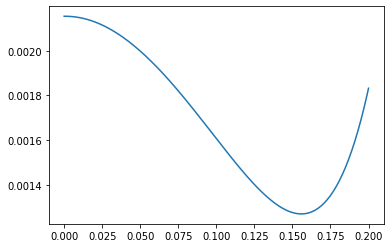

In [16]:
import matplotlib.pyplot as plt
import numpy as np

TIME = np.linspace(0,final_time,len(Energy))
plt.plot(TIME,Energy)

In [17]:

Draw (InnerProduct(div(gf_k), div(gf_k)), mesh, draw_surf=False, clipping={"x": -1, "y": 0, "z": 0})

WebGuiWidget(value={'ngsolve_version': '6.2.2203', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2, 'draw_vol': True…

BaseWebGuiScene

In [19]:
import ngsolve.internal
ngsolve.internal.SnapShot("foo.bmp")
Draw (InnerProduct(gf_g, gf_g), mesh, draw_surf=False, clipping={"x": -1, "y": 0, "z": 0})

WebGuiWidget(value={'ngsolve_version': '6.2.2203', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2, 'draw_vol': True…

BaseWebGuiScene